# Model training

In [328]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRFRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import PredefinedSplit

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import make_pipeline as imb_make_pipeline

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [300]:
df_final = pd.read_csv("data_for_model.csv")
data = df_final.drop(columns=["Unnamed: 0", "CAMIS", "ClosestWorkingTankDis", "ClosestBadTankDis"])
df_final.head()

,Unnamed: 0,CAMIS,ZIPCODE,CUISINE DESCRIPTION,GRADE,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,...,BORO_Staten Island,RESULT,Pop,White,Black,Hispanic,Native,Asian,Inc,Unemp
0,0,30112340,2.801389,2.913240,3.0,0.226460,4.392523,0.0,1.0,0.0,...,0.0,0.0,2501.0,12.2,63.2,18.4,2.4,1.6,35028.0,11.5
1,1,30191841,2.831125,2.814634,3.0,0.004614,1.120030,0.0,0.0,1.0,...,0.0,0.0,5195.0,72.9,3.6,8.4,0.0,12.3,141678.0,4.7
2,2,40356018,2.868895,2.834724,3.0,0.315359,9.367778,0.0,1.0,0.0,...,0.0,0.0,2185.0,38.0,2.2,40.8,0.0,19.1,20040.0,12.2
3,3,40356731,2.771028,2.896149,3.0,0.787235,6.038144,0.0,1.0,0.0,...,0.0,0.0,3627.0,2.6,81.3,12.5,0.0,3.6,19842.0,6.8
4,4,40357217,2.744246,2.834724,3.0,0.158258,6.767919,1.0,0.0,0.0,...,0.0,0.0,8433.0,5.1,22.8,70.8,0.0,0.0,12999.0,17.4


### Convert To Binary Problem

In [301]:
data.loc[data['GRADE'] == 1, 'GRADE'] = 1
data.loc[data['GRADE'] == 2, "GRADE"] = 1
data.loc[data['GRADE'] == 3, "GRADE"] = 0

In [302]:
print("FAILING RESTAURANTS", data.loc[data['GRADE'] == 1]["Pop"].mean())
print("PASSING RESTAURANTS",data.loc[data['GRADE'] == 0]["Pop"].mean())

FAILING RESTAURANTS 4990.663870246085
PASSING RESTAURANTS 4754.9435549186965


### Train Test Split and Scaling

In [303]:
dev, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data["GRADE"])
train, val = train_test_split(dev, test_size = 0.2,  random_state=42)

# train, val = train_test_split(dev, test_size=0.2, random_state=42)

dev_Y = dev["GRADE"].astype(int)
train_Y = train["GRADE"].astype(int)
val_Y = val["GRADE"].astype(int)
test_Y = test["GRADE"].astype(int)

dev_X = dev.drop(columns=["GRADE"])
train_X = train.drop(columns=["GRADE"])
val_X = val.drop(columns=["GRADE"])

test_X = test.drop(columns=["GRADE"])

# scaling numerical_data
scaler = StandardScaler()
dev_X[["Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.fit_transform(dev_X[["Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])
train_X[["Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.fit_transform(train_X[["Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])

val_X[["Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.transform(val_X[["Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])
test_X[["Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.transform(test_X[["Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])

dev_X.head()

,ZIPCODE,CUISINE DESCRIPTION,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,RESULT,Pop,White,Black,Hispanic,Native,Asian,Inc,Unemp
15118,2.683585,2.885072,0.0,0.0,1.0,0.0,0.0,0.0,-0.604044,0.354815,-0.024763,-0.625849,0.903908,0.107517,-1.087705,-0.187551
5574,2.784988,2.688088,0.0,0.0,1.0,0.0,0.0,0.0,-1.061239,0.047322,-0.501599,-0.914678,0.159945,1.763977,0.599620,-0.702372
2302,2.849024,2.675366,0.0,1.0,0.0,0.0,0.0,1.0,-0.430087,-0.181590,-0.501599,1.006475,0.159945,-0.500624,-0.319628,-0.428873
11164,2.823677,2.733296,0.0,0.0,1.0,0.0,0.0,0.0,0.580946,1.205546,-0.581072,-0.827154,-0.265176,-0.309494,1.265653,-0.332344
8746,2.752518,2.601703,0.0,1.0,0.0,0.0,0.0,0.0,-0.327497,0.064405,0.988513,-0.608344,0.266226,-0.674379,-0.107268,-0.026669


### Baseline Model

ROC AUC from constant prediction model:  0.5
Average Precision from constant prediction model:  0.47359102980230156


<AxesSubplot:>

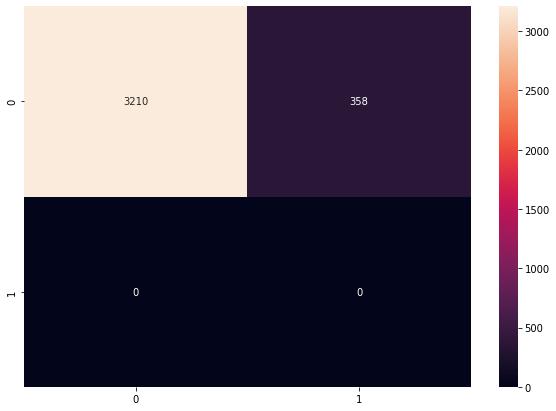

In [304]:
# Baseline model -- would just predict 3 everytime
constant_pred = np.repeat(0, test.shape[0])
base_acc = accuracy_score(constant_pred, test_Y)
# base_roc_auc = roc_auc_score(constant_pred, test_Y)
print("ROC AUC from constant prediction model: ", roc_auc_score(test_Y, constant_pred))
print("Average Precision from constant prediction model: ", f1_score(test_Y, constant_pred, average="macro"))

base_conf = confusion_matrix(constant_pred, test_Y)

plt.figure(figsize = (10,7))
sn.heatmap(base_conf, annot=True,  fmt='g')


### ROS

In [305]:
# resampling or other feature engineering techniques
ros = RandomOverSampler()
train_ROS = ros.fit_resample(train_X, train_Y)
train_ROS_X = train_ROS[0]
train_ROS_Y = train_ROS[1]

dev_ROS = ros.fit_resample(dev_X, dev_Y)
dev_ROS_X = dev_ROS[0]
dev_ROS_Y = dev_ROS[1]


In [306]:
# resampling or other feature engineering techniques
sm = SMOTE()
train_SMOTE = sm.fit_resample(train_X, train_Y)
train_SMOTE_X = train_SMOTE[0]
train_SMOTE_Y = train_SMOTE[1]

dev_SMOTE = sm.fit_resample(dev_X, dev_Y)
dev_SMOTE_X = dev_SMOTE[0]
dev_SMOTE_Y = dev_SMOTE[1]


### Lets see how a baseline logistic regression model does on original and sampled data

In [307]:
# Original Data
scores = cross_validate(LogisticRegression(), dev_X, dev_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6502254177422567
Mean AP from 5-fold CV:  0.17969719446857751


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [308]:
# SMOTE Data
scores = cross_validate(LogisticRegression(), dev_SMOTE_X, dev_SMOTE_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6747163079458418
Mean AP from 5-fold CV:  0.6443829291966253


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [319]:
# Random Over Sampling
scores = cross_validate(LogisticRegression(), dev_ROS_X, dev_ROS_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6566044182650254
Mean AP from 5-fold CV:  0.6467978843288896


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [337]:
# Undersampling
rus = RandomUnderSampler(replacement=False, random_state=42)
pipe = imb_make_pipeline(rus, LogisticRegression())
scores = cross_validate(pipe, dev_X, dev_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV (Random Undersampling): ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: (Random Undersampling)", scores['test_average_precision'].mean())

/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV (Random Undersampling):  0.6432964043350099
Mean AP from 5-fold CV: (Random Undersampling) 0.17587499410324642


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [320]:
scores = cross_validate(RandomForestClassifier(), dev_SMOTE_X, dev_SMOTE_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

Mean AUC from 5-fold CV:  0.9366504025713042
Mean AP from 5-fold CV:  0.9319373268209237


In [338]:
scores = cross_validate(XGBClassifier(), dev_SMOTE_X, dev_SMOTE_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

Mean AUC from 5-fold CV:  0.9566956415968445
Mean AP from 5-fold CV:  0.9642917474528847


In [339]:
xg_boost_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

xg_boost_grid_params = {'n_estimators': np.random.randint(100,400,4), 
                        'max_depth': np.random.randint(1,10,3), 
                        "learning_rate": np.random.uniform(0.01, 0.3, 4)
}

# # Fit the random search model
grid = RandomizedSearchCV(estimator=xg_boost_model, param_distributions=xg_boost_grid_params, cv=5, scoring="roc_auc", verbose=5, n_iter=10)
grid.fit(dev_SMOTE_X, dev_SMOTE_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.2579912021339521, max_depth=4, n_estimators=185;, score=0.810 total time=   1.1s
[CV 2/5] END learning_rate=0.2579912021339521, max_depth=4, n_estimators=185;, score=0.986 total time=   1.3s
[CV 3/5] END learning_rate=0.2579912021339521, max_depth=4, n_estimators=185;, score=0.988 total time=   1.1s
[CV 4/5] END learning_rate=0.2579912021339521, max_depth=4, n_estimators=185;, score=0.987 total time=   1.2s
[CV 5/5] END learning_rate=0.2579912021339521, max_depth=4, n_estimators=185;, score=0.988 total time=   1.2s
[CV 1/5] END learning_rate=0.2579912021339521, max_depth=7, n_estimators=155;, score=0.836 total time=   1.6s
[CV 2/5] END learning_rate=0.2579912021339521, max_depth=7, n_estimators=155;, score=0.992 total time=   1.6s
[CV 3/5] END learning_rate=0.2579912021339521, max_depth=7, n_estimators=155;, score=0.993 total time=   1.6s
[CV 4/5] END learning_rate=0.2579912021339521, max_depth=7,

In [343]:
optimal_SMOTE_xg = XGBClassifier(n_estimators =343, max_depth=7, learning_rate=0.078)
optimal_SMOTE_xg.fit(dev_SMOTE_X, dev_SMOTE_Y)
optimal_SMOTE_xg_preds = optimal_SMOTE_xg.predict(test_X)

print("Tuned Final model has ROC AUC value of: ", roc_auc_score(test_Y, optimal_SMOTE_xg_preds))


Tuned Final model has ROC AUC value of:  0.5588141109312728


Final Model's confusion matrix:


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


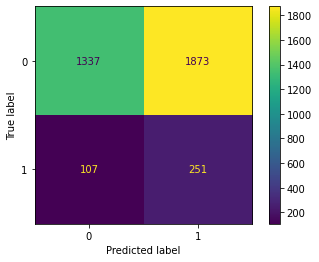

In [332]:
print("Final Model's confusion matrix:")
plot_confusion_matrix(optimal_SMOTE_xg, test_X, test_Y)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

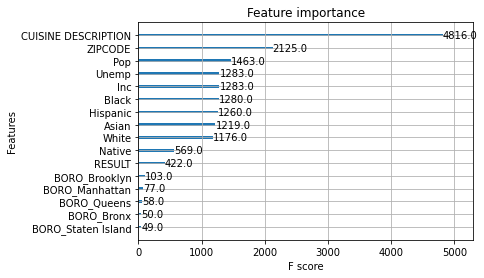

In [340]:
plot_importance(optimal_SMOTE_xg)

In [333]:
xg_pred_proba = optimal_SMOTE_xg.predict_proba(test_X)[:, 1]
model_1_fpr, model_1_tpr, _ = roc_curve(test_Y, xg_pred_proba, pos_label=1)
model_1_prec, model_1_recall, _ = precision_recall_curve(test_Y, xg_pred_proba)

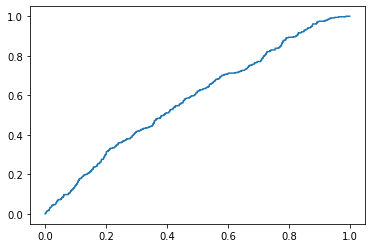

In [344]:
plt.plot(model_1_fpr, model_1_tpr, label="No Sampling")

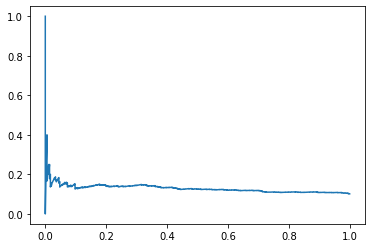

In [336]:
plt.plot(model_1_recall, model_1_prec, label="No Sampling")


XGBoost F1 score (SMOTE) 0.3476822250639386


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

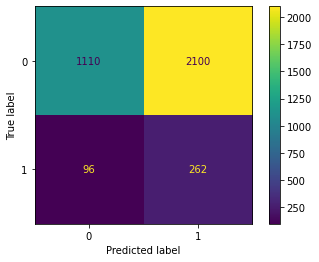

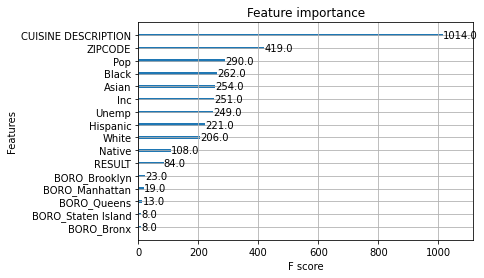

In [314]:
xg_SMOTE = XGBClassifier(use_label_encoder=False)
xg_SMOTE.fit(dev_SMOTE_X, dev_SMOTE_Y)
xg_SMOTE_preds = xg_SMOTE.predict(test_X)

plot_confusion_matrix(xg_SMOTE, test_X, test_Y)
# print("XGBoost Multi Class ROC AUC score (SMOTE)", myscore(xg_SMOTE, test_X, test_Y))
print("XGBoost F1 score (SMOTE)", f1_score(test_Y, xg_SMOTE_preds, average="macro"))
plot_importance(xg_SMOTE)

XGBoost F1 score (ROS) 0.5094089100372466


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


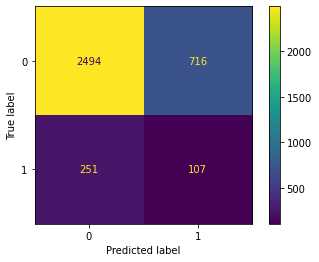

In [315]:
xg_ROS = XGBClassifier(use_label_encoder=False)
xg_ROS.fit(train_ROS_X, train_ROS_Y)
xg_ROS_preds = xg_ROS.predict(test_X)

plot_confusion_matrix(xg_ROS, test_X, test_Y)
# print("XGBoost Multi Class ROC AUC score (ROS)", myscore(xg_ROS, test_X, test_Y))
print("XGBoost F1 score (ROS)", f1_score(test_Y, xg_ROS_preds, average="macro"))

XGBoost F1 score (Weighted) 0.5063175608346348


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


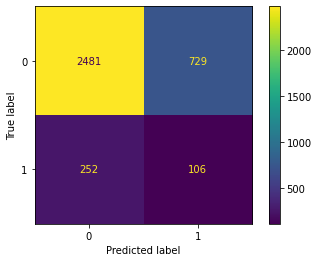

In [316]:
# XG Boost with class weights
from sklearn.utils import class_weight

xg_weighted = XGBClassifier(use_label_encoder=False)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=dev_Y
)

xg_weighted.fit(dev_X, dev_Y, sample_weight=classes_weights)
xg_weighted_preds = xg_weighted.predict(test_X)
print("XGBoost F1 score (Weighted)", f1_score(test_Y, xg_weighted_preds, average="macro"))

plot_confusion_matrix(xg_weighted, test_X, test_Y)
# print("XGBoost Multi Class ROC AUC score (Class-Weighted)", myscore(xg_weighted, test_X, test_Y))


In [317]:
rf_model = RandomForestClassifier(class_weight="balanced")

rf_boost_grid_params = {'n_estimators': [100, 200, 300, 400], 
                        'max_depth': [4, 6, 8], 
                        "min_samples_split": [2,4,6,8]}

# # Fit the random search model
grid = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_boost_grid_params, cv=5, scoring="roc_auc", verbose=5, n_iter=10)
grid.fit(dev_SMOTE_X, dev_SMOTE_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with SMOTE were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=8, min_samples_split=4, n_estimators=100;, score=0.761 total time=   1.4s
[CV 2/5] END max_depth=8, min_samples_split=4, n_estimators=100;, score=0.850 total time=   1.4s
[CV 3/5] END max_depth=8, min_samples_split=4, n_estimators=100;, score=0.870 total time=   1.4s
[CV 4/5] END max_depth=8, min_samples_split=4, n_estimators=100;, score=0.853 total time=   1.4s
[CV 5/5] END max_depth=8, min_samples_split=4, n_estimators=100;, score=0.862 total time=   1.3s
[CV 1/5] END max_depth=6, min_samples_split=6, n_estimators=200;, score=0.736 total time=   2.2s
[CV 2/5] END max_depth=6, min_samples_split=6, n_estimators=200;, score=0.807 total time=   2.2s
[CV 3/5] END max_depth=6, min_samples_split=6, n_estimators=200;, score=0.828 total time=   2.2s
[CV 4/5] END max_depth=6, min_samples_split=6, n_estimators=200;, score=0.810 total time=   2.1s
[CV 5/5] END max_depth=6, min_samples_split=6, n_estimators=200;, 

KeyboardInterrupt: 

Tuned RF Model has ROC AUC score:  0.5759028176612889


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


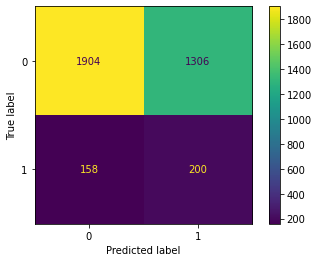

In [ ]:
optimal_rf_model = RandomForestClassifier(n_estimators=300, min_samples_split=2, max_depth=8)
optimal_rf_model.fit(dev_SMOTE_X, dev_SMOTE_Y)

optimal_rf_model_preds = optimal_rf_model.predict(test_X)
print("Tuned RF Model has ROC AUC score: ", roc_auc_score(test_Y, optimal_rf_model_preds))
plot_confusion_matrix(optimal_rf_model, test_X, test_Y)


In [ ]:
xg_boost_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

xg_boost_grid_params = {'n_estimators': np.random.randint(100,400,4), 
                        'max_depth': np.random.randint(1,10,3), 
                        "learning_rate": np.random.uniform(0.01, 0.3, 4),
                        "scale_pos_weight": [1,10,25,50,75,99]}


# # Fit the random search model
grid = RandomizedSearchCV(estimator=xg_boost_model, param_distributions=xg_boost_grid_params, cv=5, scoring="roc_auc", verbose=5, n_iter=10)
grid.fit(dev_ROS_X, dev_ROS_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.23742532921880005, max_depth=5, n_estimators=264, scale_pos_weight=75;, score=0.902 total time=   1.6s
[CV 2/5] END learning_rate=0.23742532921880005, max_depth=5, n_estimators=264, scale_pos_weight=75;, score=0.901 total time=   1.5s
[CV 3/5] END learning_rate=0.23742532921880005, max_depth=5, n_estimators=264, scale_pos_weight=75;, score=0.912 total time=   1.5s
[CV 4/5] END learning_rate=0.23742532921880005, max_depth=5, n_estimators=264, scale_pos_weight=75;, score=0.903 total time=   1.7s
[CV 5/5] END learning_rate=0.23742532921880005, max_depth=5, n_estimators=264, scale_pos_weight=75;, score=0.899 total time=   1.5s
[CV 1/5] END learning_rate=0.07730457358311023, max_depth=6, n_estimators=264, scale_pos_weight=10;, score=0.886 total time=   1.9s
[CV 2/5] END learning_rate=0.07730457358311023, max_depth=6, n_estimators=264, scale_pos_weight=10;, score=0.882 total time=   2.0s
[CV 3/5] END le

Tuned XG Model has f1 score:  0.7561659192825112


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

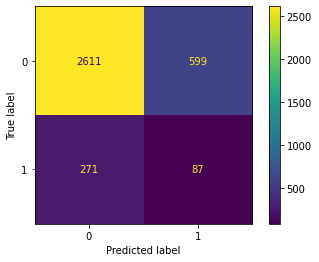

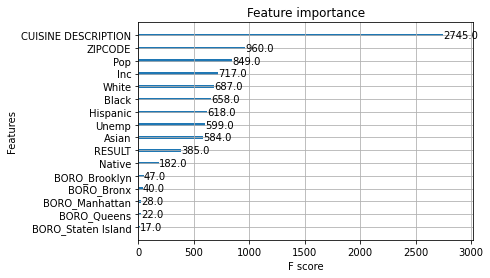

In [ ]:
optimal_XG_model = XGBClassifier(n_estimators=253, max_depth=6, learning_rate=0.23742532921880005)
optimal_XG_model.fit(dev_ROS_X, dev_ROS_Y)
optimal_XG_model_preds = optimal_XG_model.predict(test_X)
print("Tuned XG Model has f1 score: ", accuracy_score(test_Y, optimal_XG_model_preds))
plot_confusion_matrix(optimal_XG_model, test_X, test_Y)
plot_importance(optimal_XG_model)

In [ ]:
# visualization
